In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [16]:
# データの読み込み
data = pd.read_csv('dataframe.csv')
X = data.iloc[:, :-1].values  # 入力データ (スピン配位)
y = data.iloc[:, -1].values   # 教師データ (温度)

In [17]:
# データのサイズを確認
X.shape , y.shape

((25000, 100), (25000,))

In [18]:
y

array([0.01, 0.01, 0.01, ..., 6.  , 6.  , 6.  ])

In [19]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [20]:
# NumPy配列からPyTorchのテンソルに変換
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (25000,) -> (25000, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)    # (6250,) -> (6250, 1)

In [21]:
y_train

tensor([[3.0000],
        [0.5000],
        [2.2500],
        ...,
        [0.0100],
        [3.7500],
        [5.7500]])

正解データはone-hot表現にする必要がある

In [22]:
import torch

# y_trainテンソルを新しいテンソルに変換する関数を定義
def to_one_hot(y_train, num_classes=25):
    # one-hotベクトルの初期化
    one_hot = torch.zeros(len(y_train), num_classes)
    
    # 各要素を25次元のone-hotベクトルに変換
    for i, val in enumerate(y_train):
        index = int((val - 0.01) / 0.24)  # 正しいインデックスの計算
        one_hot[i, index] = 1.0
    
    return one_hot

# y_train,y_testをone-hotベクトルに変換
one_hot_y_train = to_one_hot(y_train, num_classes=25)
one_hot_y_test = to_one_hot(y_test, num_classes=25)

In [23]:
one_hot_y_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [24]:
y_train[12]

tensor([5.5000])

In [25]:
one_hot_y_train[12]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0.])

In [26]:
# データセットの作成
train_dataset = TensorDataset(X_train, one_hot_y_train)
test_dataset = TensorDataset(X_test, one_hot_y_test)

In [27]:
train_dataset[0]

(tensor([ 1.,  1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
          1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1.,
         -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
         -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,
          1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]))

画像を回転させるような前処理を実行したいができていない，

原因：各データが1次元に形を変形させてしまっているため，画像回転の前処理がエラーになってしまう

In [28]:
# 前処理を定義
#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.RandomHorizontalFlip(p=0.5),
#    transforms.RandomVerticalFlip(p=0.5),
#])
#
#train_dataset = transform(train_dataset)

In [29]:
# DataLoaderの設定（バッチサイズ1250）
train_loader = DataLoader(train_dataset, batch_size=1250, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1250)

データの参照

In [30]:
x, t = next(iter(train_loader))
x.shape, t.shape

(torch.Size([1250, 100]), torch.Size([1250, 25]))

In [31]:
for x, t in train_loader:
    print(t)
    print(t.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([1250, 25])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([1250, 25])
tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([1250, 25])
tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0

In [32]:
# ニューラルネットワークモデルの定義
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [33]:
# モデルの初期化
input_size = 100
hidden_size = 64
output_size = 25
model = NeuralNetwork(input_size, hidden_size, output_size)

In [34]:
# モデルの中身を確認
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=25, bias=True)
)


In [35]:
# 損失関数と最適化アルゴリズムの設定
criterion = nn.CrossEntropyLoss()   # クロスエントロピー誤差を採用
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)     # Adamという最適化手法を採用,L2正則化を設定

In [36]:
# 学習の実行
num_epochs = 7500
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)      # outputの一番値が大きい成分
        targets = torch.argmax(targets, dim=1)  # targetの一番値が大きい成分
        running_acc += torch.mean(pred.eq(targets).float()) # predとtargetが同じになった数の平均
        optimizer.step()
    running_loss /= len(train_loader)   # 12500個の訓練データ全体での損失関数の平均
    running_acc /= len(train_loader)    # 12500個の訓練データ全体での正解率
    train_losses.append(running_loss)
    train_accs.append(running_acc)
    #
    #   test loop
    #
    test_running_loss = 0.0
    test_running_acc = 0.0
    for test_inputs, test_targets in test_loader:
        test_output = model(test_inputs)
        test_loss = criterion(test_output, test_targets)
        test_running_loss += test_loss.item()
        test_pred = torch.argmax(test_output, dim=1)      # outputの一番値が大きい成分
        test_targets = torch.argmax(test_targets, dim=1)  # targetの一番値が大きい成分
        test_running_acc += torch.mean(test_pred.eq(test_targets).float()) # predとtargetが同じになった数の平均
    test_running_loss /= len(test_loader)   # 12500個の訓練データ全体での損失関数の平均
    test_running_acc /= len(test_loader)    # 12500個の訓練データ全体での正解率
    test_losses.append(test_running_loss)
    test_accs.append(test_running_acc)
        
    print("epoch: {}, loss: {}, acc: {}, test loss: {}, test acc: {}".format(epoch, running_loss, running_acc, test_running_loss, test_running_acc))

c:\Users\sugay\Anaconda3\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: 0, loss: 3.2109736442565917, acc: 0.042479999363422394, test loss: 3.208908224105835, test acc: 0.04871999844908714
epoch: 1, loss: 3.202813673019409, acc: 0.07055999338626862, test loss: 3.205059766769409, test acc: 0.06047999858856201
epoch: 2, loss: 3.1951112270355226, acc: 0.08903999626636505, test loss: 3.2021817922592164, test acc: 0.06431999802589417
epoch: 3, loss: 3.1883126974105833, acc: 0.09040000289678574, test loss: 3.198360323905945, test acc: 0.06815999746322632
epoch: 4, loss: 3.1787576913833617, acc: 0.09736000001430511, test loss: 3.197310376167297, test acc: 0.06976000219583511
epoch: 5, loss: 3.172018837928772, acc: 0.10839998722076416, test loss: 3.1986115694046022, test acc: 0.07128000259399414
epoch: 6, loss: 3.1645182609558105, acc: 0.11903999745845795, test loss: 3.1992177724838258, test acc: 0.06824000179767609
epoch: 7, loss: 3.1582841157913206, acc: 0.12783999741077423, test loss: 3.1977906703948973, test acc: 0.07448000460863113
epoch: 8, loss: 3.152

KeyboardInterrupt: 

損失関数と正解率のグラフの作成

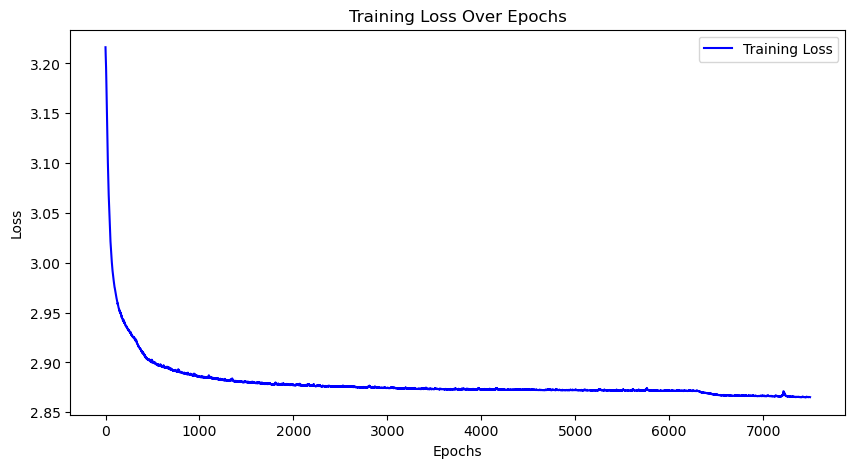

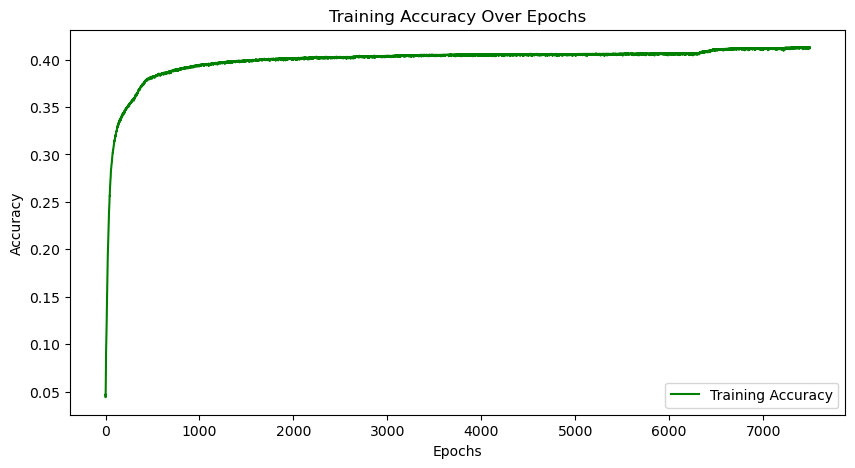

In [ ]:
# 損失関数のグラフ
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Over Epochs')
plt.show()

# 正解率のグラフ
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accs, label='Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy Over Epochs')
plt.show()

実際に予測値と正解がどうなっているか見てみる

In [ ]:
print(pred[:20])

tensor([ 7,  1, 11, 21, 22,  1, 10, 20,  5,  5,  0, 10,  0, 22, 24,  4, 16,  9,
         1, 18])


In [ ]:
print(targets[:20])

tensor([ 6,  3, 11, 21, 24,  4, 10, 18,  5,  4,  1, 19, 10, 19, 16,  8, 21,  9,
         4, 17])


モデルの保存

In [ ]:
params = model.state_dict()

In [ ]:
torch.save(params, "model.prm")